# Ejemplo de Pipelines con BD de los pasajeros del Titanic

In [1]:
# Se cargan las librerías que se van a utilizar
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import scale 
from sklearn.preprocessing import StandardScaler

In [2]:
## 1) EXTRAER DATOS
# Los datos pueden encontrarse en diferentes formatos, en nuestro caso están en formato csv.

# Se carga la base de datos
df = pd.read_csv('train_titanic.csv') #Se encuentra en la misma carpeta que el jupyter notebook

df_TEST = pd.read_csv('test_titanic.csv') #Se encuentra en la misma carpeta que el jupyter notebook

In [3]:
## 2) ANÁLISIS EXPLORATORIO
# Se realiza una descripción analítica de los datos.
print(df.shape) #Se tienen 891 renglones y 11 columnas
df.head()

(891, 11)


,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print(df_TEST.shape) #Se tienen 418 renglones y 10 columnas
df_TEST.head()

(418, 10)


,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Los datos de entrenamiento corresponden a la información de 891 pasajeros del Titanic.

La información que se tiene de cada persona es (11 columnas):

   - **survived:** Variable binaria que vale 1 si el pasajero sobrevivió y 0 si no
   - **pclass:** Clase en la que viajaba el pasajero
   - **name:** Nombre del pasajero
   - **sex:** Sexo del pasajer
   - **age:** Edad del pasajero
   - **sibSp:** Número de hermanos/cónyuges abordo
   - **parCh:** Número de padres/hijos abordo
   - **ticket:** Clave del boleto
   - **fare:** Tarifa pagada por el boleto (en unidades monetarias u.m.)
   - **cabin:** Cabina en la que se quedó el pasajero durante el viaje
   - **embarked:** Puerto en el que embarcó el pasajero. **C** = Cherbourg, **S** = Southampton, **Q** = Queenstown
   
Los datos de prueba corresponden a la información de 418 pasajeros del Titanic (10 columnas).


Se desea predecir si los pasajeros sobreviven o no de acuerdo a sus características.

In [5]:
# Se cuenta el número de NaN's por columna
df.isnull().sum()

survived      0
pclass        0
name          0
sex           0
age         177
sibsp         0
parch         0
ticket        0
fare          0
cabin       687
embarked      2
dtype: int64

In [6]:
# Se cuenta el número de NaN's por columna
df_TEST.isnull().sum()

pclass        0
name          0
sex           0
age          86
sibsp         0
parch         0
ticket        0
fare          1
cabin       327
embarked      0
dtype: int64

In [7]:
# Se eliminan las columnas 'cabin', 'ticket' y 'name' en los datos de entrenamiento.
print('Antes se tenían ',df.shape[0],'renglones y' ,df.shape[1],'columnas.')
df = df.drop(['cabin','name','ticket'], axis = 1)
print('Ahora se tienen ',df.shape[0],' renglones y ',df.shape[1],' columnas.')
print('Se eliminaron ',891-df.shape[0],' renglones y ',11-df.shape[1],' columnas.')
print(df.shape)
df.head()

Antes se tenían  891 renglones y 11 columnas.
Ahora se tienen  891  renglones y  8  columnas.
Se eliminaron  0  renglones y  3  columnas.
(891, 8)


,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [8]:
# Se eliminan las columnas 'cabin', 'ticket' y 'name' en los datos de prueba.
print('Antes se tenían ',df_TEST.shape[0],'renglones y' ,df_TEST.shape[1],'columnas.')
df_TEST = df_TEST.drop(['cabin','name','ticket'], axis = 1)
print('Ahora se tienen ',df_TEST.shape[0],' renglones y ',df_TEST.shape[1],' columnas.')
print('Se eliminaron ',418-df_TEST.shape[0],' renglones y ',10-df_TEST.shape[1],' columnas.')
print(df_TEST.shape)
df_TEST.head()

Antes se tenían  418 renglones y 10 columnas.
Ahora se tienen  418  renglones y  7  columnas.
Se eliminaron  0  renglones y  3  columnas.
(418, 7)


,pclass,sex,age,sibsp,parch,fare,embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


Vamos a eliminar las columnas _sibsp_ y _parch_.

Se van a cambiar por una columna llamada _CompAl (travel with company or alone)_.

Esta nueva columna va a tener un 1 en el _i-_ ésimo renglón si $sibsp_{i} + parch_{i} > 0$ y $0$ si no.

Nos va a indicar si un pasajero viajaba acompañado (1) o solo (0).

In [9]:
# Creamos la nueva columna con las características mencionadas, para los datos de entrenamiento
df['CompAl']=np.where((df["sibsp"]+df["parch"])>0, 1, 0)
print(df.head())

#Eliminamos las columnas 'SibSp' y 'ParCh'
df.drop('sibsp', axis=1, inplace=True)
df.drop('parch', axis=1, inplace=True)

df.head()

   survived  pclass     sex   age  sibsp  parch     fare embarked  CompAl
0         0       3    male  22.0      1      0   7.2500        S       1
1         1       1  female  38.0      1      0  71.2833        C       1
2         1       3  female  26.0      0      0   7.9250        S       0
3         1       1  female  35.0      1      0  53.1000        S       1
4         0       3    male  35.0      0      0   8.0500        S       0


,survived,pclass,sex,age,fare,embarked,CompAl
0,0,3,male,22.0,7.2500,S,1
1,1,1,female,38.0,71.2833,C,1
2,1,3,female,26.0,7.9250,S,0
3,1,1,female,35.0,53.1000,S,1
4,0,3,male,35.0,8.0500,S,0


In [10]:
# Creamos la nueva columna con las características mencionadas, para los datos de prueba
df_TEST['CompAl']=np.where((df_TEST["sibsp"]+df_TEST["parch"])>0, 1, 0)
print(df_TEST.head())

#Eliminamos las columnas 'SibSp' y 'ParCh'
df_TEST.drop('sibsp', axis=1, inplace=True)
df_TEST.drop('parch', axis=1, inplace=True)

df_TEST.head()

   pclass     sex   age  sibsp  parch     fare embarked  CompAl
0       3    male  34.5      0      0   7.8292        Q       0
1       3  female  47.0      1      0   7.0000        S       1
2       2    male  62.0      0      0   9.6875        Q       0
3       3    male  27.0      0      0   8.6625        S       0
4       3  female  22.0      1      1  12.2875        S       1


,pclass,sex,age,fare,embarked,CompAl
0,3,male,34.5,7.8292,Q,0
1,3,female,47.0,7.0000,S,1
2,2,male,62.0,9.6875,Q,0
3,3,male,27.0,8.6625,S,0
4,3,female,22.0,12.2875,S,1


In [11]:
#Se definen los nombres de las variables numéricas, categóricas y ordinales
numerical = df.select_dtypes(include=np.number).columns.tolist()
numerical.remove('pclass') #Variable ordinal
numerical.remove('survived') #Variable Y

nominal = df.select_dtypes(exclude=np.number).columns.tolist()

ordinal = ['pclass']

print('nominal:\n',nominal,'\n')
print('ordinal:\n',ordinal,'\n')
print('numerical:\n',numerical,'\n')

nominal:
 ['sex', 'embarked'] 

ordinal:
 ['pclass'] 

numerical:
 ['age', 'fare', 'CompAl'] 



In [12]:
## 4) DIVIDIR LOS DATOS
# Se separan los datos en 2 grupos:
X = df[nominal + ordinal + numerical]
Y = df['survived']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size = 0.2,random_state = 44)

X_REAL_test = df_TEST[nominal + ordinal + numerical]

In [13]:
X.head()

,sex,embarked,pclass,age,fare,CompAl
0,male,S,3,22.0,7.2500,1
1,female,C,1,38.0,71.2833,1
2,female,S,3,26.0,7.9250,0
3,female,S,1,35.0,53.1000,1
4,male,S,3,35.0,8.0500,0


In [14]:
X_REAL_test.head()

,sex,embarked,pclass,age,fare,CompAl
0,male,Q,3,34.5,7.8292,0
1,female,S,3,47.0,7.0000,1
2,male,Q,2,62.0,9.6875,0
3,male,S,3,27.0,8.6625,0
4,female,S,3,22.0,12.2875,1


## Pipelines para transformar las columnas

In [15]:
# Datos nominales: Se indica que se llenan los datos con la moda
nom_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                     ("encoder", OneHotEncoder(sparse=True, handle_unknown="ignore"))])

# Datos ordinales: Se indica que se llenan los datos con la moda
ord_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                     ("encoder", OrdinalEncoder())])

# Datos numéricos: Se indica que se llenan los datos con la media
num_pipe = Pipeline([("imputer", SimpleImputer(strategy="mean")),
                     ("scaler", StandardScaler())])

# Se utiliza la función 'ColumnTransformer' con los tres pipelines
preprocessing_pipeline = ColumnTransformer([
    ("nominal_preprocessor", nom_pipe, nominal),
    ("ordinal_preprocessor", ord_pipe, ordinal),
    ("numerical_preprocessor", num_pipe, numerical)])


## Pipeline con modelo

In [16]:
## 5) CONSTRUIR UN MODELO
# En este ejemplo vamos a elegir un modelo de regresión logística para "X_train"
logmodel = LogisticRegression()
complete_pipe_logReg = Pipeline([("preprocessor", preprocessing_pipeline),
                                 ("estimator", logmodel)])
#logmodel.fit(X_train,Y_train) ##ANTES
complete_pipe_logReg.fit(X_train, Y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nominal_preprocessor',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'embarked']),
                                                 ('ordinal_preprocessor',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                   

In [17]:
## 6) PREDICCIONES
# Se hacen las predicciones con "X_test"
#Y_pred = logmodel.predict(X_test) ##ANTES
Y_pred = complete_pipe_logReg.predict(X_REAL_test)

[[  0 262]
 [  1 156]]


Text(0, 0.5, 'Número de pasajeros')

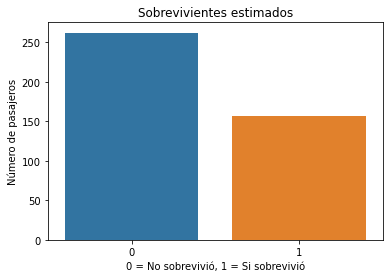

In [18]:
unique, counts = np.unique(Y_pred, return_counts=True)
print(np.asarray((unique, counts)).T)
sns.countplot(x=Y_pred, data=df_TEST)
plt.title('Sobrevivientes estimados')
plt.xlabel('0 = No sobrevivió, 1 = Si sobrevivió')
plt.ylabel('Número de pasajeros')

In [19]:
## 7) EVALUACIÓN DEL MODELO
print('Score = ',round(complete_pipe_logReg.score(X_train, Y_train) * 100, 2),
      '% = Tasa de respuestas correctas del modelo en el conjunto de entrenamiento')

Score =  81.46 % = Tasa de respuestas correctas del modelo en el conjunto de entrenamiento


# Conclusiones

La tasa de respuestas correctas del modelo en el conjunto de entrenamiento es del 81.46 % (sin grid).

Los resultados obtenidos son:

     - 262 no sobrevivientes
     - 156 sobrevivientes

De acuerdo a las gráficas mostradas, 

   - La mayoría de los pasajeros que sobrevieron fueron mujeres de las clases 1 y 2.
   - El número de hombres que no sobreviveron es un poco más del doble que el número de mujeres que no sobreviveron.
   - La clase con el mayor número de pasajeros entre 20 y 30 años es la tercera clase.
   - La mayoría de los pasajeros eran hombres jóvenes que viajaban solos.